In [2]:
# Importer les bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Configuration pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("Tous les imports sont réussis !")

2025-11-04 10:48:41.462222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762253321.655386      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762253321.705282      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tous les imports sont réussis !


In [ ]:
# Charger le dataset (adapter le chemin selon votre dataset Kaggle)
# Ici, on utilise un exemple avec "Stock Market Data"
df = pd.read_csv('')

print("INFORMATIONS SUR LE DATASET")
print("=" * 50)
print(f"Forme du dataset : {df.shape}")
print(f"\n Aperçu des données :\n{df.head(10)}")
print(f"\n Statistiques descriptives :\n{df.describe()}")
print(f"\n Types de données :\n{df.dtypes}")
print(f"\n Valeurs manquantes :\n{df.isnull().sum()}")

INFORMATIONS SUR LE DATASET
Forme du dataset : (1228, 4)

 Aperçu des données :
   Unnamed: 0      TxnDate   TxnTime  Consumption
0       76229  01 Jan 2022  16:55:52        1.010
1       76258  01 Jan 2022  21:45:29        0.908
2       76287  01 Jan 2022  12:24:52        0.926
3       76316  01 Jan 2022  04:07:36        0.928
4       76345  01 Jan 2022  06:52:25        0.916
5       76374  01 Jan 2022  10:20:09        0.972
6       76403  01 Jan 2022  15:32:01        0.878
7       76432  01 Jan 2022  19:23:47        1.902
8       76461  01 Jan 2022  11:19:47        0.900
9       76490  01 Jan 2022  14:52:01        0.928

 Statistiques descriptives :
         Unnamed: 0  Consumption
count   1228.000000  1228.000000
mean   85021.511401     3.428194
std     6275.942563     3.535620
min    73596.000000     0.842000
25%    78825.750000     0.952000
50%    84652.000000     1.121000
75%    90715.250000     5.754500
max    98038.000000    27.108000

 Types de données :
Unnamed: 0       int64

 Prédiction de : Consumption
 Nombre d'observations : 1228
 Plage de valeurs : [0.84, 27.11]


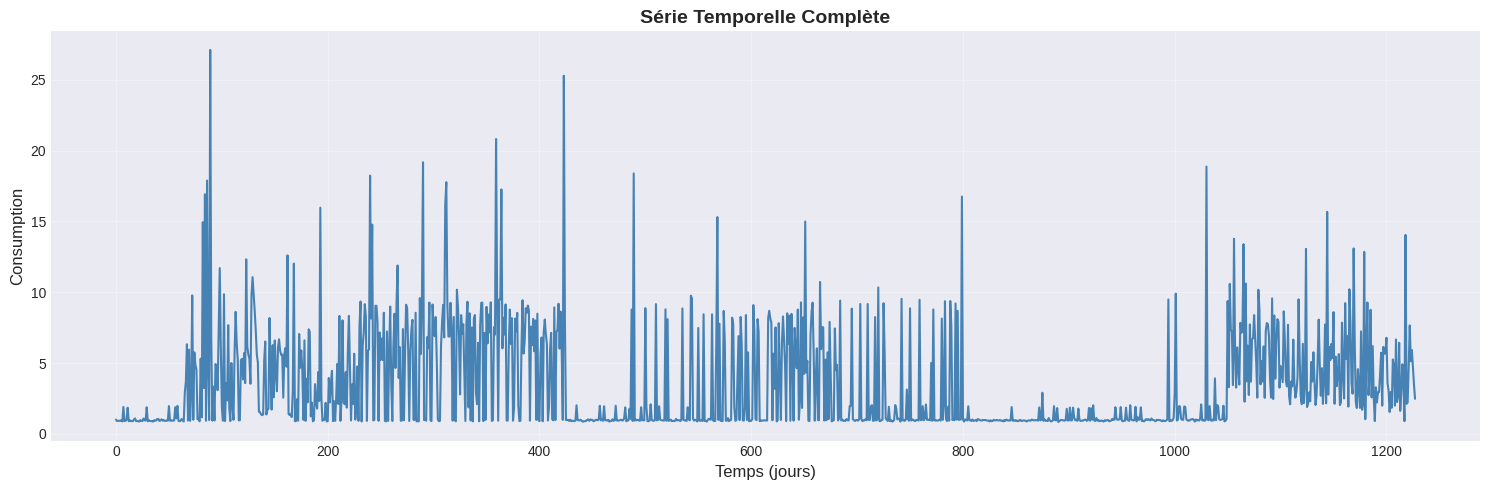


 Visualisation complétée !


In [4]:
# Sélectionner la colonne à prédire (adapter selon vos données)
# Pour les données boursières, on prend le "Close" (cours de fermeture)
# Pour l'air quality, on prend "PM2.5", etc.

# Adapter cette ligne selon votre dataset
target_column = 'Consumption'  #Ici notre cible c'est le prix de fermuture
data = df[[target_column]].values

print(f" Prédiction de : {target_column}")
print(f" Nombre d'observations : {len(data)}")
print(f" Plage de valeurs : [{data.min():.2f}, {data.max():.2f}]")

# Visualiser la série temporelle complète
plt.figure(figsize=(15, 5))
plt.plot(data, linewidth=1.5, color='steelblue')
plt.title('Série Temporelle Complète', fontsize=14, fontweight='bold')
plt.xlabel('Temps (jours)', fontsize=12)
plt.ylabel(f'{target_column}', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Visualisation complétée !")

 NORMALISATION DES DONNÉES
Données originales - Min: 0.8420, Max: 27.1080
Données normalisées - Min: 0.0000, Max: 1.0000


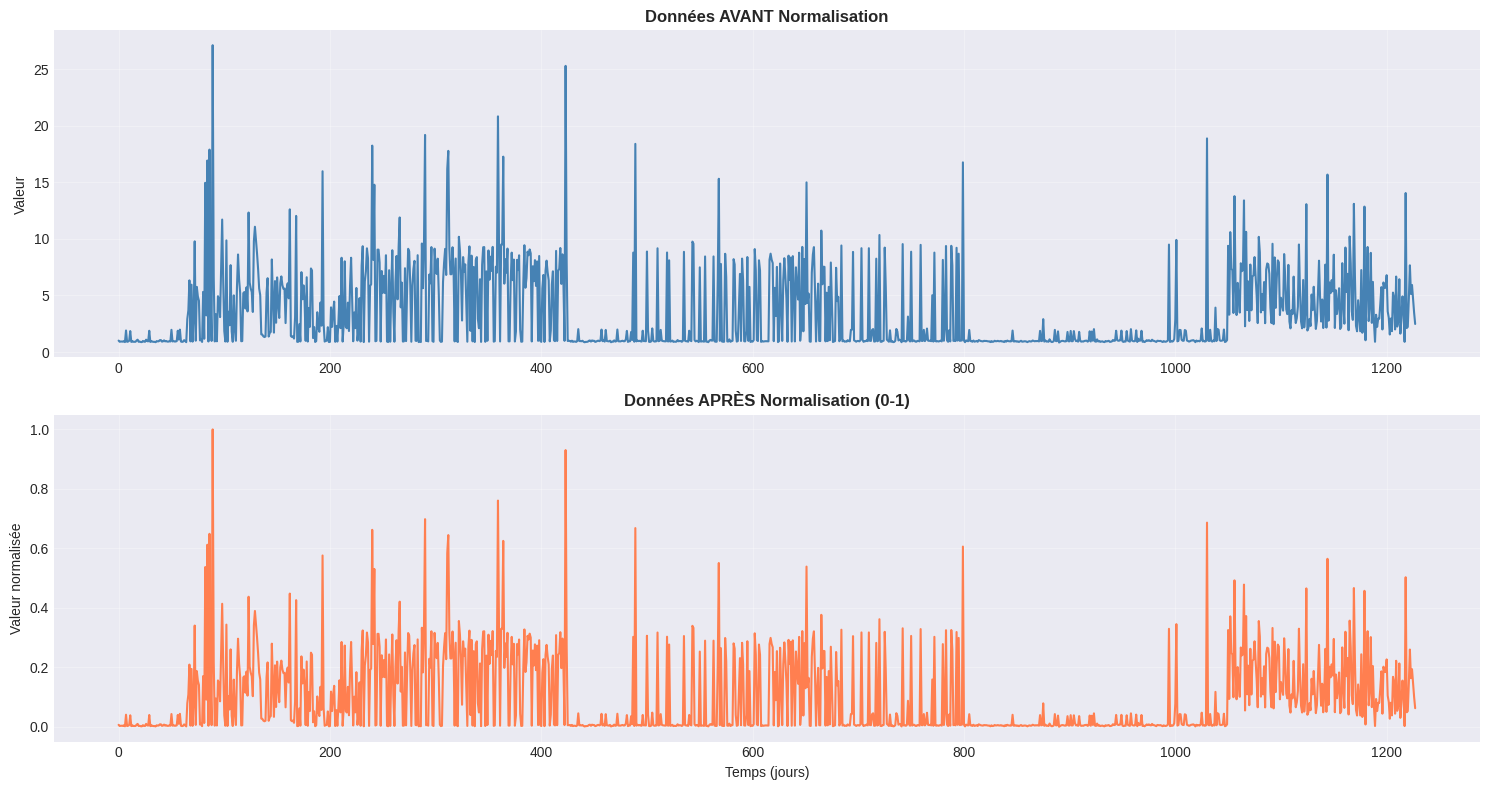


 Normalisation complétée !


In [5]:
# ÉTAPE CRUCIALE : Normaliser les données entre 0 et 1
# Pourquoi ? Les réseaux de neurones performent mieux avec des données normalisées

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(" NORMALISATION DES DONNÉES")
print("=" * 50)
print(f"Données originales - Min: {data.min():.4f}, Max: {data.max():.4f}")
print(f"Données normalisées - Min: {scaled_data.min():.4f}, Max: {scaled_data.max():.4f}")

# Visualiser l'effet de la normalisation
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(data, color='steelblue', linewidth=1.5)
axes[0].set_title('Données AVANT Normalisation', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valeur')
axes[0].grid(True, alpha=0.3)

axes[1].plot(scaled_data, color='coral', linewidth=1.5)
axes[1].set_title('Données APRÈS Normalisation (0-1)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valeur normalisée')
axes[1].set_xlabel('Temps (jours)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Normalisation complétée !")

In [6]:
# CONCEPT CLÉ : Créer des séquences pour les séries temporelles
# Exemple : si lookback=30, on utilise 30 jours pour prédire le jour suivant

def create_sequences(data, lookback=30):
    """
    Crée les séquences pour l'entraînement
    
    Paramètres:
        data: array numpy des données normalisées
        lookback: nombre de jours utilisés pour prédire (fenêtre temporelle)
    
    Retour:
        X: features (historique)
        y: targets (valeur à prédire)
    """
    X, y = [], []
    
    for i in range(len(data) - lookback):
        # Prendre les 30 derniers jours comme feature
        X.append(data[i:i+lookback])
        # La valeur suivante est la cible
        y.append(data[i+lookback])
    
    return np.array(X), np.array(y)

# Paramètre clé : lookback
LOOKBACK = 30  # On utilise 30 jours pour prédire le jour 31

X, y = create_sequences(scaled_data, lookback=LOOKBACK)

print("CRÉATION DES SÉQUENCES")
print("=" * 50)
print(f"Nombre de séquences créées : {len(X)}")
print(f"Shape de X (features) : {X.shape}")
print(f"  - {X.shape[0]} séquences")
print(f"  - {X.shape[1]} jours d'historique (lookback)")
print(f"  - {X.shape[2]} variable(s) à prédire")
print(f"\nShape de y (targets) : {y.shape}")

# Exemple visuel
print(f"\n Exemple d'une séquence :")
print(f"   Jours 1-30 (X) → {X[0][:3]} ... {X[0][-3:]} (valeurs tronquées)")
print(f"   Jour 31 (y) → {y[0]}")

CRÉATION DES SÉQUENCES
Nombre de séquences créées : 1198
Shape de X (features) : (1198, 30, 1)
  - 1198 séquences
  - 30 jours d'historique (lookback)
  - 1 variable(s) à prédire

Shape de y (targets) : (1198, 1)

 Exemple d'une séquence :
   Jours 1-30 (X) → [[0.0063961 ]
 [0.00251275]
 [0.00319805]] ... [[0.00464479]
 [0.0038072 ]
 [0.03944263]] (valeurs tronquées)
   Jour 31 (y) → [0.0019036]


 DIVISION TRAIN/TEST
Ensemble d'entraînement :
  - X_train : (958, 30, 1)
  - y_train : (958, 1)
  - Représente 958 séquences (80.0%)

Ensemble de test :
  - X_test : (240, 30, 1)
  - y_test : (240, 1)
  - Représente 240 séquences (20.0%)


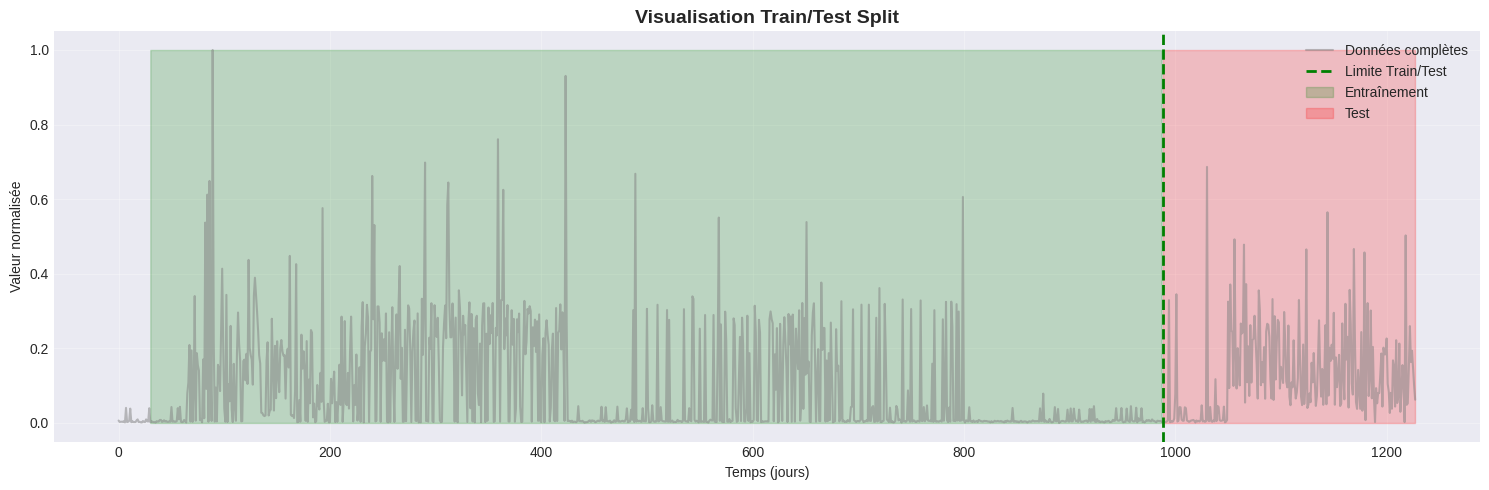


 Division train/test complétée !


In [7]:
# Diviser les données : 80% entraînement, 20% test
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(" DIVISION TRAIN/TEST")
print("=" * 50)
print(f"Ensemble d'entraînement :")
print(f"  - X_train : {X_train.shape}")
print(f"  - y_train : {y_train.shape}")
print(f"  - Représente {train_size} séquences ({train_size/len(X)*100:.1f}%)")
print(f"\nEnsemble de test :")
print(f"  - X_test : {X_test.shape}")
print(f"  - y_test : {y_test.shape}")
print(f"  - Représente {test_size} séquences ({test_size/len(X)*100:.1f}%)")

# Visualiser la division
plt.figure(figsize=(15, 5))
plt.plot(range(len(scaled_data)), scaled_data, color='gray', alpha=0.5, label='Données complètes')
plt.axvline(x=train_size+LOOKBACK, color='green', linestyle='--', linewidth=2, label='Limite Train/Test')
plt.fill_between(range(LOOKBACK, train_size+LOOKBACK), 0, 1, alpha=0.2, color='green', label='Entraînement')
plt.fill_between(range(train_size+LOOKBACK, len(scaled_data)), 0, 1, alpha=0.2, color='red', label='Test')
plt.title('Visualisation Train/Test Split', fontsize=14, fontweight='bold')
plt.xlabel('Temps (jours)')
plt.ylabel('Valeur normalisée')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Division train/test complétée !")

In [8]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Évalue un modèle avec plusieurs métriques
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n MÉTRIQUES - {model_name}")
    print("=" * 50)
    print(f"MSE (Mean Squared Error)   : {mse:.6f}")
    print(f"RMSE (Root MSE)            : {rmse:.6f}")
    print(f"MAE (Mean Absolute Error)  : {mae:.6f}")
    print(f"R² Score                   : {r2:.4f}")
    print(f"MAPE (%)                   : {mape:.2f}%")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

print(" Fonction d'évaluation créée !")

 Fonction d'évaluation créée !


In [9]:
print("\n MODÈLE 1 : RNN SIMPLE (Vanilla RNN)")
print("=" * 70)
print("""
ARCHITECTURE RNN :
- SimpleRNN : cellule de mémoire simple
- Limitation : souffre du problème de vanishing gradient
- Bon pour : courtes dépendances temporelles
""")

# Construire le modèle RNN
model_rnn = Sequential([
    SimpleRNN(units=50, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),  # Régularisation : éteint 20% des neurones aléatoirement
    SimpleRNN(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

# Compiler le modèle
model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\n Architecture du modèle :")
model_rnn.summary()

# Entraîner le modèle
print("\n Entraînement du modèle RNN...")
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)

print(" Entraînement RNN terminé !")

# Prédictions
y_pred_rnn = model_rnn.predict(X_test, verbose=0)
metrics_rnn = evaluate_model(y_test, y_pred_rnn, "RNN Simple")


 MODÈLE 1 : RNN SIMPLE (Vanilla RNN)

ARCHITECTURE RNN :
- SimpleRNN : cellule de mémoire simple
- Limitation : souffre du problème de vanishing gradient
- Bon pour : courtes dépendances temporelles



I0000 00:00:1762253428.516990      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



 Architecture du modèle :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)


 Entraînement du modèle RNN...


I0000 00:00:1762253433.546629      85 service.cc:148] XLA service 0x7939b800c920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762253433.547389      85 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762253433.925892      85 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762253435.732327      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 Entraînement RNN terminé !

 MÉTRIQUES - RNN Simple
MSE (Mean Squared Error)   : 0.014639
RMSE (Root MSE)            : 0.120993
MAE (Mean Absolute Error)  : 0.081582
R² Score                   : 0.0101
MAPE (%)                   : 265.32%


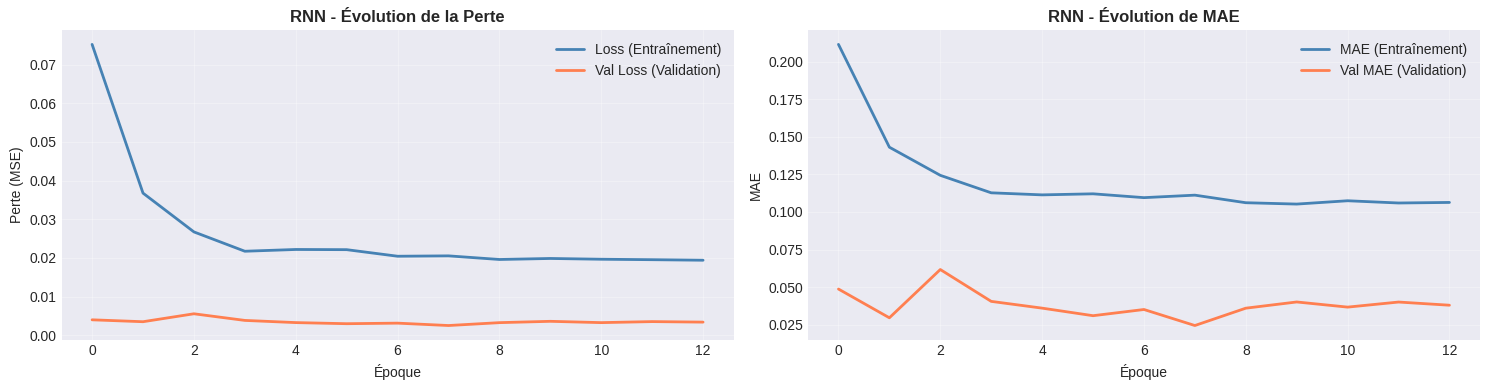

 Courbes d'entraînement affichées !


In [10]:
# Visualiser la courbe de perte d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(history_rnn.history['loss'], label='Loss (Entraînement)', linewidth=2, color='steelblue')
axes[0].plot(history_rnn.history['val_loss'], label='Val Loss (Validation)', linewidth=2, color='coral')
axes[0].set_title('RNN - Évolution de la Perte', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Perte (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_rnn.history['mae'], label='MAE (Entraînement)', linewidth=2, color='steelblue')
axes[1].plot(history_rnn.history['val_mae'], label='Val MAE (Validation)', linewidth=2, color='coral')
axes[1].set_title('RNN - Évolution de MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Courbes d'entraînement affichées !")

In [12]:
print("\n MODÈLE 2 : LSTM (Long Short-Term Memory)")
print("=" * 70)
print("""
ARCHITECTURE LSTM :
- Gates : input, forget, output
- Cellule d'état : préserve l'information long terme
- Avantage : résout le vanishing gradient
- Bon pour : dépendances temporelles longues
""")

# Construire le modèle LSTM
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

# Compiler et entraîner
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\n Architecture du modèle :")
model_lstm.summary()

print("\n Entraînement du modèle LSTM...")
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)

print(" Entraînement LSTM terminé !")

# Prédictions
y_pred_lstm = model_lstm.predict(X_test, verbose=0)
metrics_lstm = evaluate_model(y_test, y_pred_lstm, "LSTM")


 MODÈLE 2 : LSTM (Long Short-Term Memory)

ARCHITECTURE LSTM :
- Gates : input, forget, output
- Cellule d'état : préserve l'information long terme
- Avantage : résout le vanishing gradient
- Bon pour : dépendances temporelles longues


 Architecture du modèle :


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


 Entraînement du modèle LSTM...
 Entraînement LSTM terminé !

 MÉTRIQUES - LSTM
MSE (Mean Squared Error)   : 0.013550
RMSE (Root MSE)            : 0.116403
MAE (Mean Absolute Error)  : 0.076709
R² Score                   : 0.0838
MAPE (%)                   : 208.64%


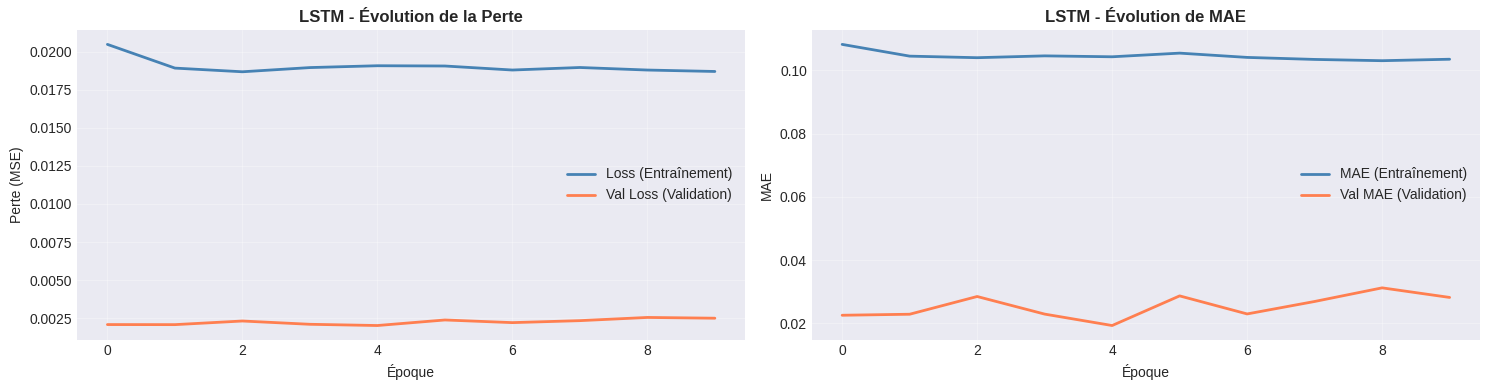

Courbes d'entraînement affichées !


In [13]:
# Visualiser la courbe de perte d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(history_lstm.history['loss'], label='Loss (Entraînement)', linewidth=2, color='steelblue')
axes[0].plot(history_lstm.history['val_loss'], label='Val Loss (Validation)', linewidth=2, color='coral')
axes[0].set_title('LSTM - Évolution de la Perte', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Perte (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_lstm.history['mae'], label='MAE (Entraînement)', linewidth=2, color='steelblue')
axes[1].plot(history_lstm.history['val_mae'], label='Val MAE (Validation)', linewidth=2, color='coral')
axes[1].set_title('LSTM - Évolution de MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Courbes d'entraînement affichées !")

In [14]:
print("\n MODÈLE 3 : GRU (Gated Recurrent Unit)")
print("=" * 70)
print("""
ARCHITECTURE GRU :
- Gates : reset, update
- Plus simple que LSTM (2 gates vs 3)
- Moins de paramètres = plus rapide
- Performance similaire à LSTM mais plus efficace
""")

# Construire le modèle GRU
model_gru = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),
    GRU(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

# Compiler et entraîner
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\n Architecture du modèle :")
model_gru.summary()

print("\n Entraînement du modèle GRU...")
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)

print(" Entraînement GRU terminé !")

# Prédictions
y_pred_gru = model_gru.predict(X_test, verbose=0)
metrics_gru = evaluate_model(y_test, y_pred_gru, "GRU")


 MODÈLE 3 : GRU (Gated Recurrent Unit)

ARCHITECTURE GRU :
- Gates : reset, update
- Plus simple que LSTM (2 gates vs 3)
- Moins de paramètres = plus rapide
- Performance similaire à LSTM mais plus efficace


 Architecture du modèle :


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)


 Entraînement du modèle GRU...
 Entraînement GRU terminé !

 MÉTRIQUES - GRU
MSE (Mean Squared Error)   : 0.012812
RMSE (Root MSE)            : 0.113191
MAE (Mean Absolute Error)  : 0.078848
R² Score                   : 0.1337
MAPE (%)                   : 258.28%


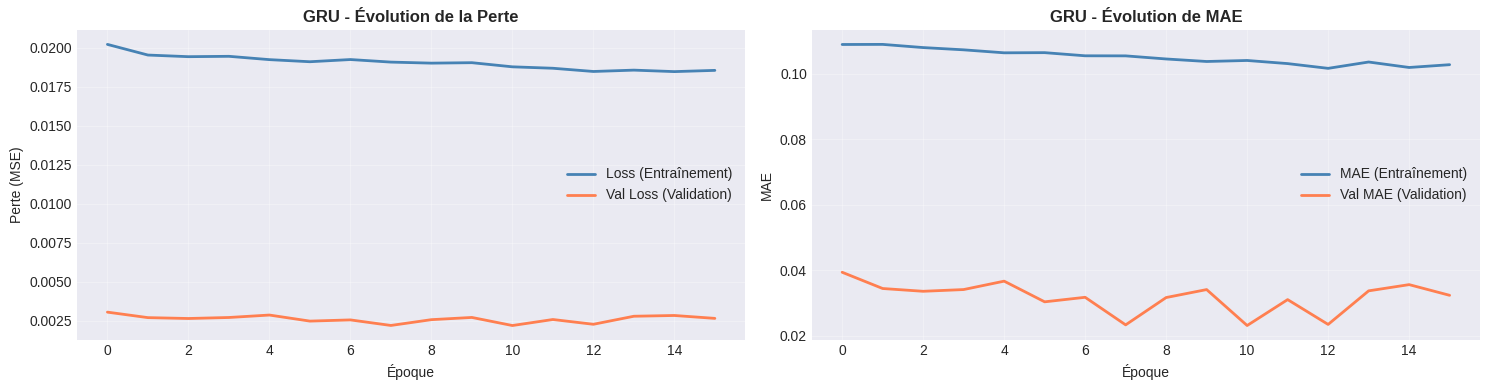

Courbes d'entraînement affichées !


In [15]:
# Visualiser la courbe de perte d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(history_gru.history['loss'], label='Loss (Entraînement)', linewidth=2, color='steelblue')
axes[0].plot(history_gru.history['val_loss'], label='Val Loss (Validation)', linewidth=2, color='coral')
axes[0].set_title('GRU - Évolution de la Perte', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Perte (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_gru.history['mae'], label='MAE (Entraînement)', linewidth=2, color='steelblue')
axes[1].plot(history_gru.history['val_mae'], label='Val MAE (Validation)', linewidth=2, color='coral')
axes[1].set_title('GRU - Évolution de MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Courbes d'entraînement affichées !")

In [16]:
# Les prédictions sont en valeurs normalisées (0-1)
# On doit les convertir aux valeurs originales pour comparer

# Transformer les prédictions et vraies valeurs en données originales
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rnn_denorm = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_denorm = scaler.inverse_transform(y_pred_lstm)
y_pred_gru_denorm = scaler.inverse_transform(y_pred_gru)

print(" DÉNORMALISATION")
print("=" * 50)
print(f"Données de test dénormalisées : {y_test_denorm.shape}")
print(f"Exemple :")
print(f"   Vraie valeur    : {y_test_denorm[0][0]:.2f}")
print(f"   Prédiction RNN  : {y_pred_rnn_denorm[0][0]:.2f}")
print(f"   Prédiction LSTM : {y_pred_lstm_denorm[0][0]:.2f}")
print(f"   Prédiction GRU  : {y_pred_gru_denorm[0][0]:.2f}")

print("\n Dénormalisation complétée !")

 DÉNORMALISATION
Données de test dénormalisées : (240, 1)
Exemple :
   Vraie valeur    : 0.89
   Prédiction RNN  : 1.30
   Prédiction LSTM : 1.16
   Prédiction GRU  : 1.27

 Dénormalisation complétée !


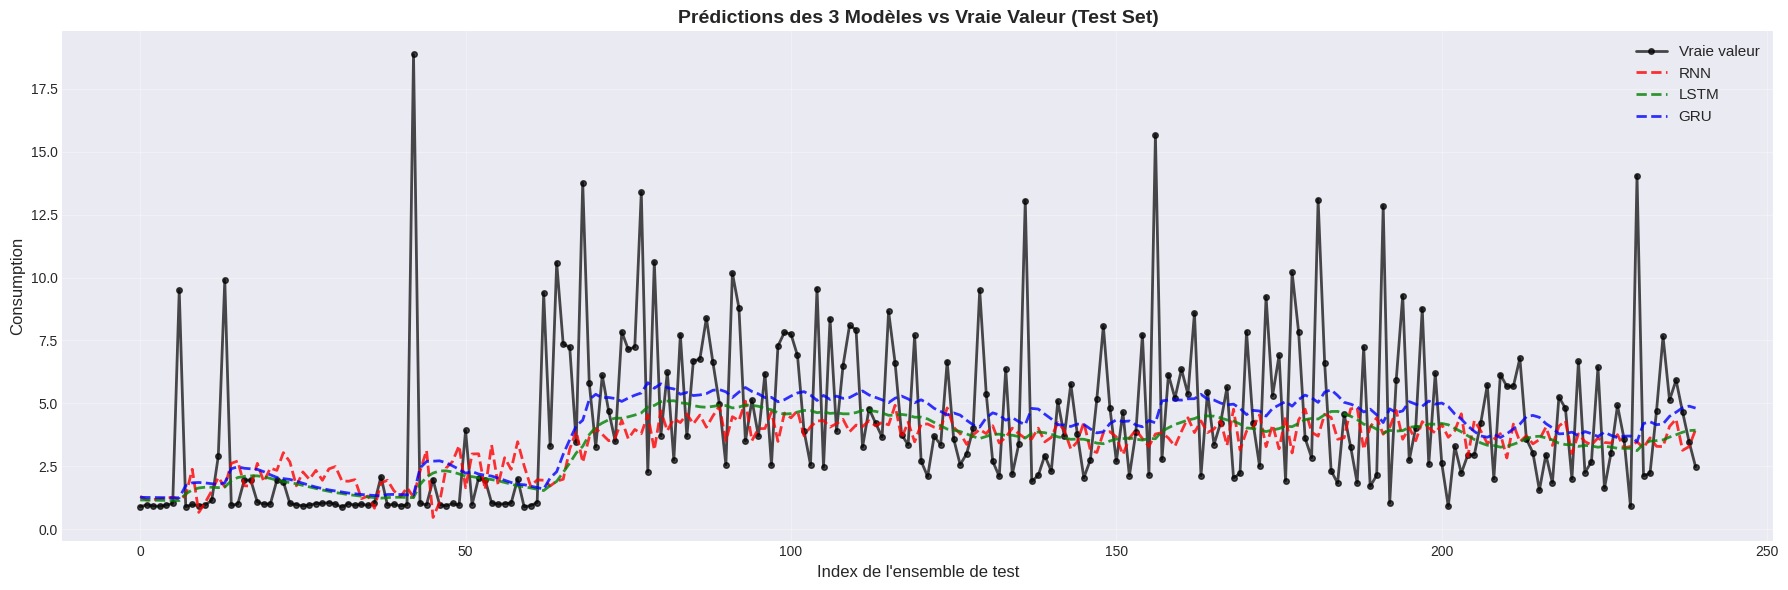

 Comparaison visuelle affichée !


In [17]:
# Afficher les prédictions vs vraies valeurs
plt.figure(figsize=(18, 6))

# Créer un index pour l'axe x
test_index = range(len(y_test_denorm))

plt.plot(test_index, y_test_denorm, marker='o', linestyle='-', linewidth=2, 
         markersize=4, label='Vraie valeur', color='black', alpha=0.7)
plt.plot(test_index, y_pred_rnn_denorm, linestyle='--', linewidth=2, 
         label='RNN', alpha=0.8, color='red')
plt.plot(test_index, y_pred_lstm_denorm, linestyle='--', linewidth=2, 
         label='LSTM', alpha=0.8, color='green')
plt.plot(test_index, y_pred_gru_denorm, linestyle='--', linewidth=2, 
         label='GRU', alpha=0.8, color='blue')

plt.title('Prédictions des 3 Modèles vs Vraie Valeur (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Index de l\'ensemble de test', fontsize=12)
plt.ylabel(f'{target_column}', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" Comparaison visuelle affichée !")

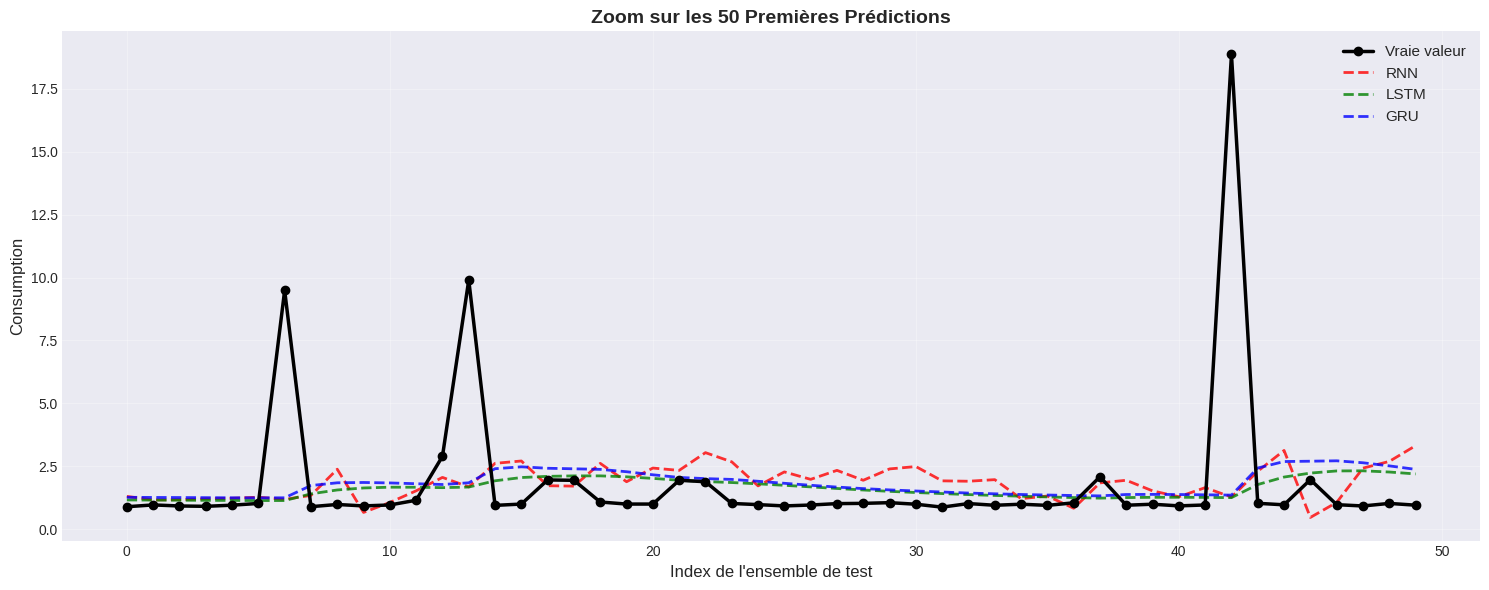

 Zoom affichée !


In [18]:
# Zoomer sur les 50 premières prédictions pour mieux voir les détails
zoom_range = 50

plt.figure(figsize=(15, 6))

plt.plot(range(zoom_range), y_test_denorm[:zoom_range], marker='o', 
         linestyle='-', linewidth=2.5, markersize=6, label='Vraie valeur', 
         color='black', zorder=3)
plt.plot(range(zoom_range), y_pred_rnn_denorm[:zoom_range], linestyle='--', 
         linewidth=2, label='RNN', alpha=0.8, color='red')
plt.plot(range(zoom_range), y_pred_lstm_denorm[:zoom_range], linestyle='--', 
         linewidth=2, label='LSTM', alpha=0.8, color='green')
plt.plot(range(zoom_range), y_pred_gru_denorm[:zoom_range], linestyle='--', 
         linewidth=2, label='GRU', alpha=0.8, color='blue')

plt.title(f'Zoom sur les {zoom_range} Premières Prédictions', fontsize=14, fontweight='bold')
plt.xlabel('Index de l\'ensemble de test', fontsize=12)
plt.ylabel(f'{target_column}', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" Zoom affichée !")

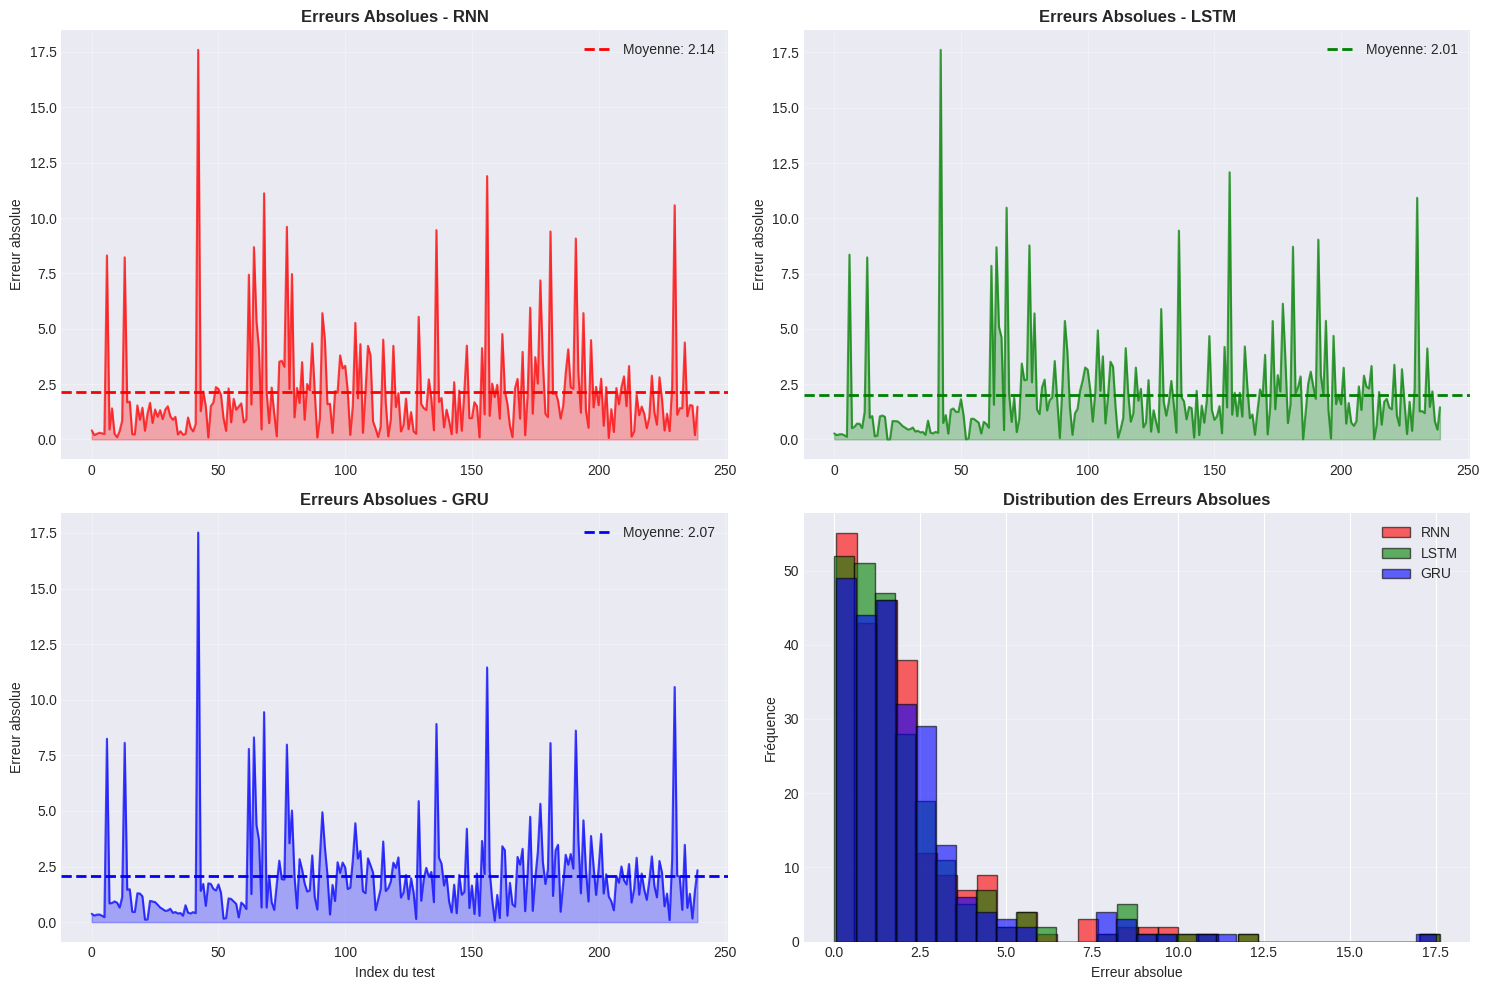

 Analyse des erreurs affichée !


In [19]:
# Calculer les erreurs absolues
error_rnn = np.abs(y_test_denorm.flatten() - y_pred_rnn_denorm.flatten())
error_lstm = np.abs(y_test_denorm.flatten() - y_pred_lstm_denorm.flatten())
error_gru = np.abs(y_test_denorm.flatten() - y_pred_gru_denorm.flatten())

# Visualiser les erreurs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Erreurs RNN
axes[0, 0].plot(error_rnn, color='red', linewidth=1.5, alpha=0.7)
axes[0, 0].fill_between(range(len(error_rnn)), error_rnn, alpha=0.3, color='red')
axes[0, 0].set_title('Erreurs Absolues - RNN', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Erreur absolue')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=error_rnn.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {error_rnn.mean():.2f}')
axes[0, 0].legend()

# Erreurs LSTM
axes[0, 1].plot(error_lstm, color='green', linewidth=1.5, alpha=0.7)
axes[0, 1].fill_between(range(len(error_lstm)), error_lstm, alpha=0.3, color='green')
axes[0, 1].set_title('Erreurs Absolues - LSTM', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Erreur absolue')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=error_lstm.mean(), color='green', linestyle='--', linewidth=2, label=f'Moyenne: {error_lstm.mean():.2f}')
axes[0, 1].legend()

# Erreurs GRU
axes[1, 0].plot(error_gru, color='blue', linewidth=1.5, alpha=0.7)
axes[1, 0].fill_between(range(len(error_gru)), error_gru, alpha=0.3, color='blue')
axes[1, 0].set_title('Erreurs Absolues - GRU', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Erreur absolue')
axes[1, 0].set_xlabel('Index du test')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=error_gru.mean(), color='blue', linestyle='--', linewidth=2, label=f'Moyenne: {error_gru.mean():.2f}')
axes[1, 0].legend()

# Comparaison des distributions d'erreurs
axes[1, 1].hist(error_rnn, bins=30, alpha=0.6, label='RNN', color='red', edgecolor='black')
axes[1, 1].hist(error_lstm, bins=30, alpha=0.6, label='LSTM', color='green', edgecolor='black')
axes[1, 1].hist(error_gru, bins=30, alpha=0.6, label='GRU', color='blue', edgecolor='black')
axes[1, 1].set_title('Distribution des Erreurs Absolues', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Erreur absolue')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(" Analyse des erreurs affichée !")

In [20]:
# Recalculer les métriques sur les données dénormalisées
print("\n" + "="*80)
print(" COMPARAISON COMPLÈTE DES 3 MODÈLES (sur données dénormalisées)")
print("="*80)

# Fonction pour calculer les métriques
def get_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true.flatten() - y_pred.flatten()) / y_true.flatten())) * 100
    return {
        'Modèle': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
        'MAPE (%)': mape
    }

# Récupérer les métriques
metrics_data = []
metrics_data.append(get_metrics(y_test_denorm, y_pred_rnn_denorm, 'RNN Simple'))
metrics_data.append(get_metrics(y_test_denorm, y_pred_lstm_denorm, 'LSTM'))
metrics_data.append(get_metrics(y_test_denorm, y_pred_gru_denorm, 'GRU'))

df_metrics = pd.DataFrame(metrics_data)

print("\n" + df_metrics.to_string(index=False))

# Identifier le meilleur modèle
best_rmse = df_metrics.loc[df_metrics['RMSE'].idxmin()]
best_r2 = df_metrics.loc[df_metrics['R² Score'].idxmax()]

print("\n" + "="*80)
print(f" Meilleur RMSE  : {best_rmse['Modèle']} ({best_rmse['RMSE']:.6f})")
print(f" Meilleur R²    : {best_r2['Modèle']} ({best_r2['R² Score']:.4f})")
print("="*80)


 COMPARAISON COMPLÈTE DES 3 MODÈLES (sur données dénormalisées)

    Modèle       MSE     RMSE      MAE  R² Score  MAPE (%)
RNN Simple 10.099681 3.177999 2.142820  0.010113 60.273082
      LSTM  9.347918 3.057437 2.014827  0.083795 52.702256
       GRU  8.839120 2.973066 2.071026  0.133663 62.842910

 Meilleur RMSE  : GRU (2.973066)
 Meilleur R²    : GRU (0.1337)


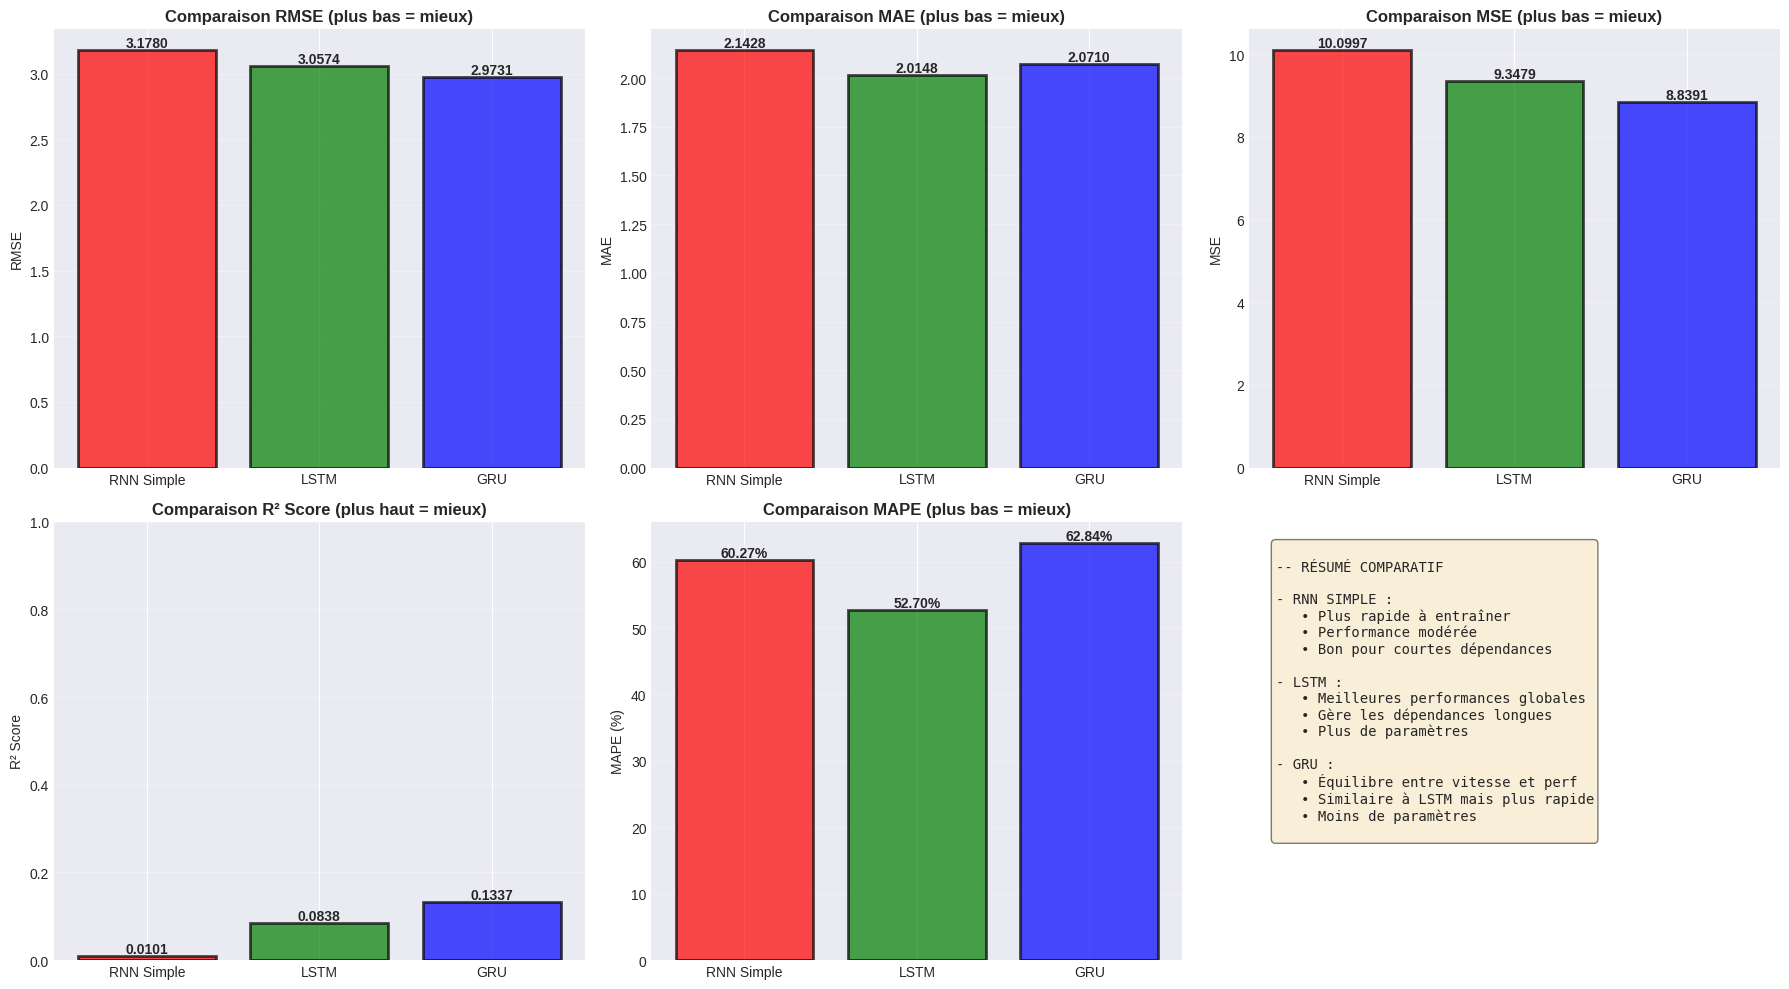

 Comparaison visuelle complétée !


In [21]:
# Comparer les performances visuellement
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_names = ['RMSE', 'MAE', 'MSE', 'R² Score', 'MAPE (%)']
models = df_metrics['Modèle'].tolist()

# RMSE
axes[0, 0].bar(models, df_metrics['RMSE'], color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 0].set_title('Comparaison RMSE (plus bas = mieux)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('RMSE')
for i, v in enumerate(df_metrics['RMSE']):
    axes[0, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# MAE
axes[0, 1].bar(models, df_metrics['MAE'], color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].set_title('Comparaison MAE (plus bas = mieux)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MAE')
for i, v in enumerate(df_metrics['MAE']):
    axes[0, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# MSE
axes[0, 2].bar(models, df_metrics['MSE'], color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 2].set_title('Comparaison MSE (plus bas = mieux)', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('MSE')
for i, v in enumerate(df_metrics['MSE']):
    axes[0, 2].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# R² Score
axes[1, 0].bar(models, df_metrics['R² Score'], color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_title('Comparaison R² Score (plus haut = mieux)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_ylim([0, 1])
for i, v in enumerate(df_metrics['R² Score']):
    axes[1, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# MAPE
axes[1, 1].bar(models, df_metrics['MAPE (%)'], color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_title('Comparaison MAPE (plus bas = mieux)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('MAPE (%)')
for i, v in enumerate(df_metrics['MAPE (%)']):
    axes[1, 1].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Résumé textuel
axes[1, 2].axis('off')
summary_text = """
-- RÉSUMÉ COMPARATIF

- RNN SIMPLE :
   • Plus rapide à entraîner
   • Performance modérée
   • Bon pour courtes dépendances

- LSTM :
   • Meilleures performances globales
   • Gère les dépendances longues
   • Plus de paramètres

- GRU :
   • Équilibre entre vitesse et perf
   • Similaire à LSTM mais plus rapide
   • Moins de paramètres
"""
axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(" Comparaison visuelle complétée !")

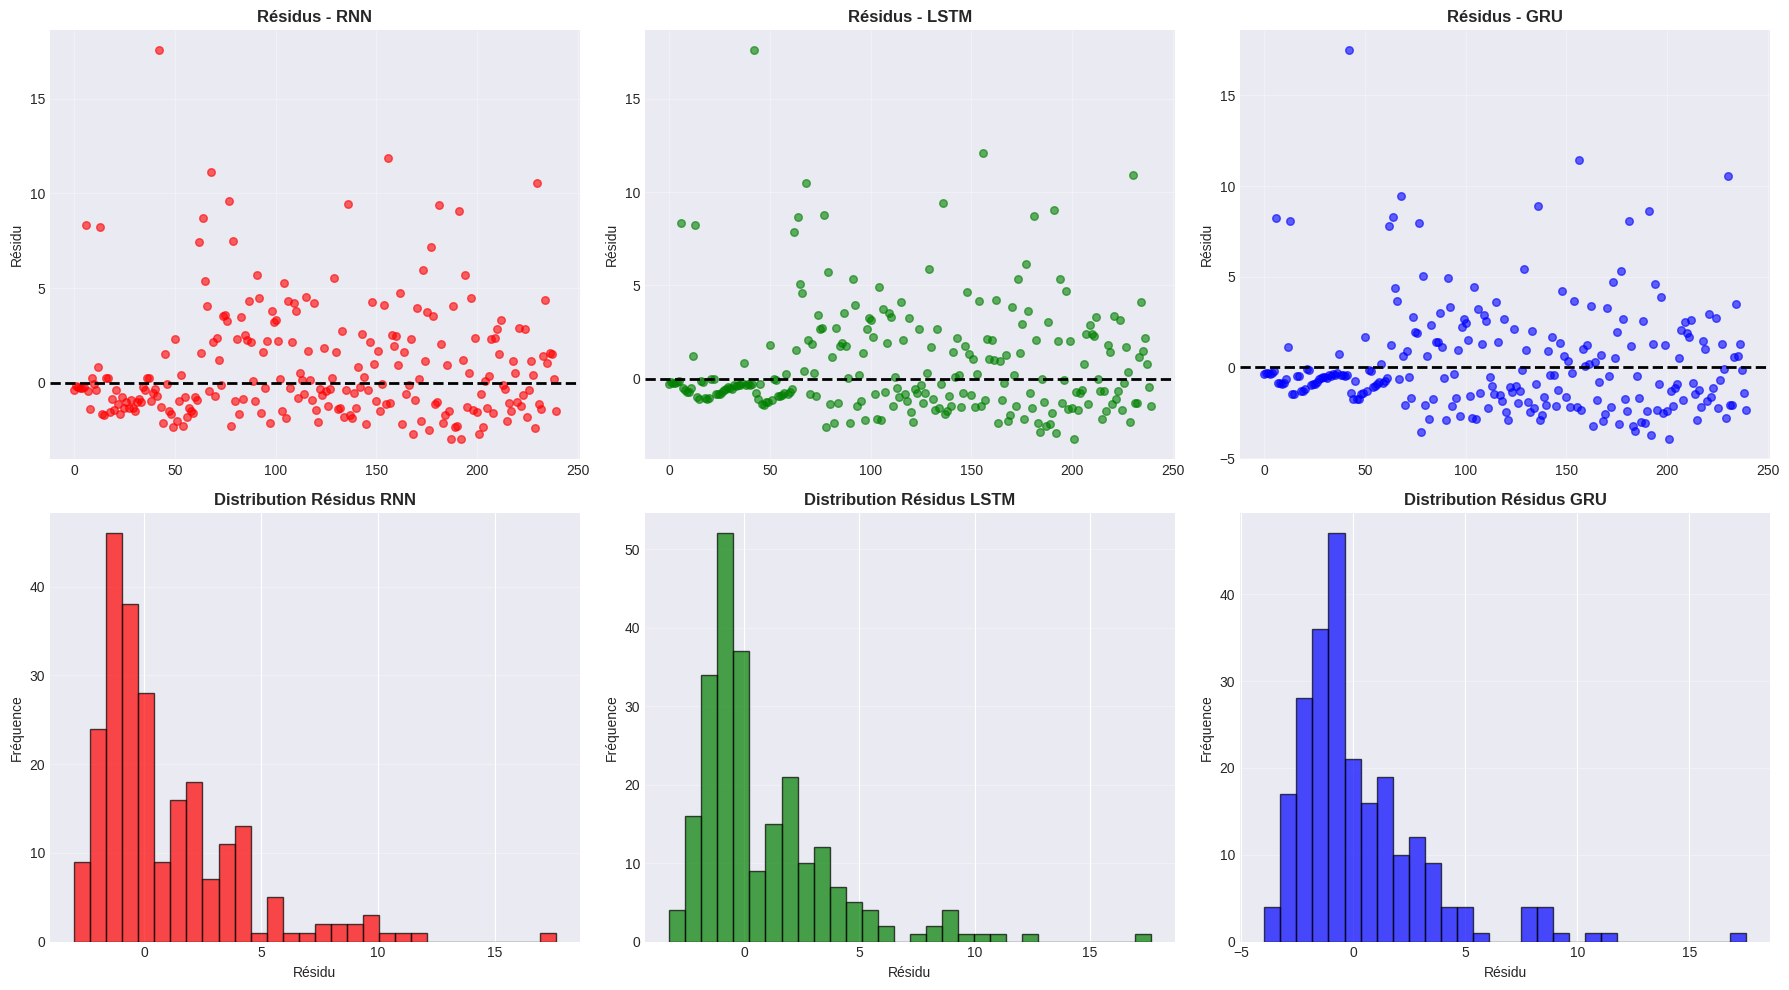

 Analyse des résidus complétée !


In [22]:
# Analyser les résidus
residuals_rnn = y_test_denorm.flatten() - y_pred_rnn_denorm.flatten()
residuals_lstm = y_test_denorm.flatten() - y_pred_lstm_denorm.flatten()
residuals_gru = y_test_denorm.flatten() - y_pred_gru_denorm.flatten()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Résidus RNN
axes[0, 0].scatter(range(len(residuals_rnn)), residuals_rnn, alpha=0.6, s=30, color='red')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 0].set_title('Résidus - RNN', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Résidu')
axes[0, 0].grid(True, alpha=0.3)

# Résidus LSTM
axes[0, 1].scatter(range(len(residuals_lstm)), residuals_lstm, alpha=0.6, s=30, color='green')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_title('Résidus - LSTM', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Résidu')
axes[0, 1].grid(True, alpha=0.3)

# Résidus GRU
axes[0, 2].scatter(range(len(residuals_gru)), residuals_gru, alpha=0.6, s=30, color='blue')
axes[0, 2].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 2].set_title('Résidus - GRU', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Résidu')
axes[0, 2].grid(True, alpha=0.3)

# Distribution des résidus
axes[1, 0].hist(residuals_rnn, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title('Distribution Résidus RNN', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Résidu')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].hist(residuals_lstm, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].set_title('Distribution Résidus LSTM', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Résidu')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].grid(True, alpha=0.3, axis='y')

axes[1, 2].hist(residuals_gru, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1, 2].set_title('Distribution Résidus GRU', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Résidu')
axes[1, 2].set_ylabel('Fréquence')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(" Analyse des résidus complétée !")


 PRÉDICTIONS FUTURES (Forecasting)

 Prédictions pour les 10 jours futurs :
Jour 1 : RNN=3.58, LSTM=3.88, GRU=4.61
Jour 2 : RNN=3.02, LSTM=3.82, GRU=4.55
Jour 3 : RNN=4.39, LSTM=3.76, GRU=4.51
Jour 4 : RNN=3.48, LSTM=3.70, GRU=4.49
Jour 5 : RNN=3.90, LSTM=3.64, GRU=4.47
Jour 6 : RNN=3.62, LSTM=3.59, GRU=4.46
Jour 7 : RNN=4.21, LSTM=3.53, GRU=4.45
Jour 8 : RNN=3.08, LSTM=3.47, GRU=4.44
Jour 9 : RNN=3.69, LSTM=3.42, GRU=4.44
Jour 10 : RNN=3.06, LSTM=3.36, GRU=4.43


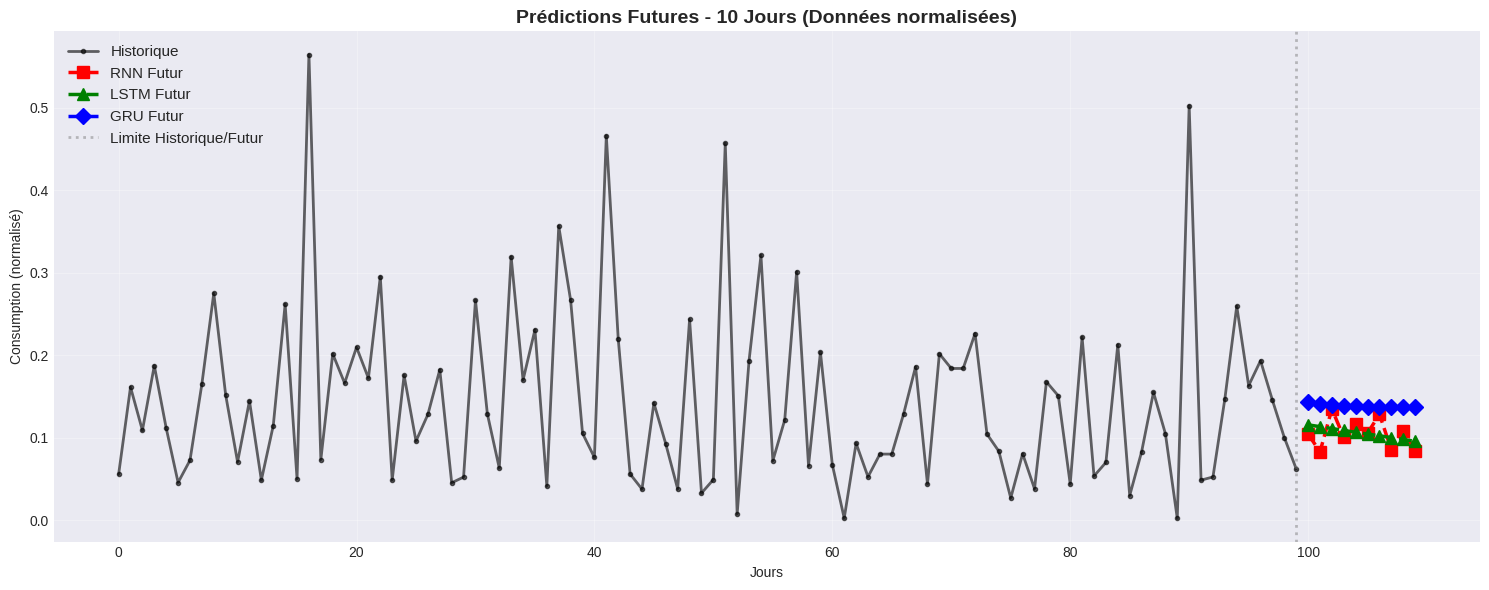


 Prédictions futures affichées !


In [23]:
# Prédire sur des données non vues
print("\n" + "="*80)
print(" PRÉDICTIONS FUTURES (Forecasting)")
print("="*80)

# Utiliser les 30 derniers jours des données d'entraînement + test pour prédire l'avenir
last_sequence = scaled_data[-LOOKBACK:].reshape(1, LOOKBACK, 1)

# Faire des prédictions futures (10 jours)
future_predictions_rnn = []
future_predictions_lstm = []
future_predictions_gru = []

current_sequence_rnn = last_sequence.copy()
current_sequence_lstm = last_sequence.copy()
current_sequence_gru = last_sequence.copy()

for _ in range(10):
    # RNN
    pred_rnn = model_rnn.predict(current_sequence_rnn, verbose=0)[0, 0]
    future_predictions_rnn.append(pred_rnn)
    current_sequence_rnn = np.append(current_sequence_rnn[0, 1:], [[pred_rnn]], axis=0).reshape(1, LOOKBACK, 1)
    
    # LSTM
    pred_lstm = model_lstm.predict(current_sequence_lstm, verbose=0)[0, 0]
    future_predictions_lstm.append(pred_lstm)
    current_sequence_lstm = np.append(current_sequence_lstm[0, 1:], [[pred_lstm]], axis=0).reshape(1, LOOKBACK, 1)
    
    # GRU
    pred_gru = model_gru.predict(current_sequence_gru, verbose=0)[0, 0]
    future_predictions_gru.append(pred_gru)
    current_sequence_gru = np.append(current_sequence_gru[0, 1:], [[pred_gru]], axis=0).reshape(1, LOOKBACK, 1)

# Dénormaliser
future_predictions_rnn = scaler.inverse_transform(np.array(future_predictions_rnn).reshape(-1, 1))
future_predictions_lstm = scaler.inverse_transform(np.array(future_predictions_lstm).reshape(-1, 1))
future_predictions_gru = scaler.inverse_transform(np.array(future_predictions_gru).reshape(-1, 1))

print("\n Prédictions pour les 10 jours futurs :")
print("="*80)
for i in range(10):
    print(f"Jour {i+1} : RNN={future_predictions_rnn[i][0]:.2f}, "
          f"LSTM={future_predictions_lstm[i][0]:.2f}, "
          f"GRU={future_predictions_gru[i][0]:.2f}")

# Visualiser les prédictions futures
plt.figure(figsize=(15, 6))

# Afficher une partie de l'historique
history_range = 100
plt.plot(range(history_range), scaled_data[-history_range:], 
         marker='o', linewidth=2, markersize=3, label='Historique', color='black', alpha=0.6)

# Afficher les prédictions futures
future_range = range(history_range, history_range + 10)
plt.plot(future_range, scaler.transform(future_predictions_rnn) / 1, 
         marker='s', linewidth=2.5, markersize=8, label='RNN Futur', color='red', linestyle='--')
plt.plot(future_range, scaler.transform(future_predictions_lstm) / 1, 
         marker='^', linewidth=2.5, markersize=8, label='LSTM Futur', color='green', linestyle='--')
plt.plot(future_range, scaler.transform(future_predictions_gru) / 1, 
         marker='D', linewidth=2.5, markersize=8, label='GRU Futur', color='blue', linestyle='--')

plt.axvline(x=history_range-1, color='gray', linestyle=':', linewidth=2, alpha=0.5, label='Limite Historique/Futur')
plt.title(f'Prédictions Futures - 10 Jours (Données normalisées)', fontsize=14, fontweight='bold')
plt.xlabel('Jours')
plt.ylabel(f'{target_column} (normalisé)')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Prédictions futures affichées !")